
Performance Metrics:
max_speedup: 7.673685215737499
avg_speedup: 1.2048828937835874
best_thread_count: 16
best_size: 50000000
best_implementation: Fortran Parallel
avg_cpp_fortran_diff: -87.93323567991268

System Information:
platform: Linux-5.15.146.1-microsoft-standard-WSL2-x86_64-with-glibc2.29
processor: x86_64
cpu_count: 12
memory_total: 8167608320


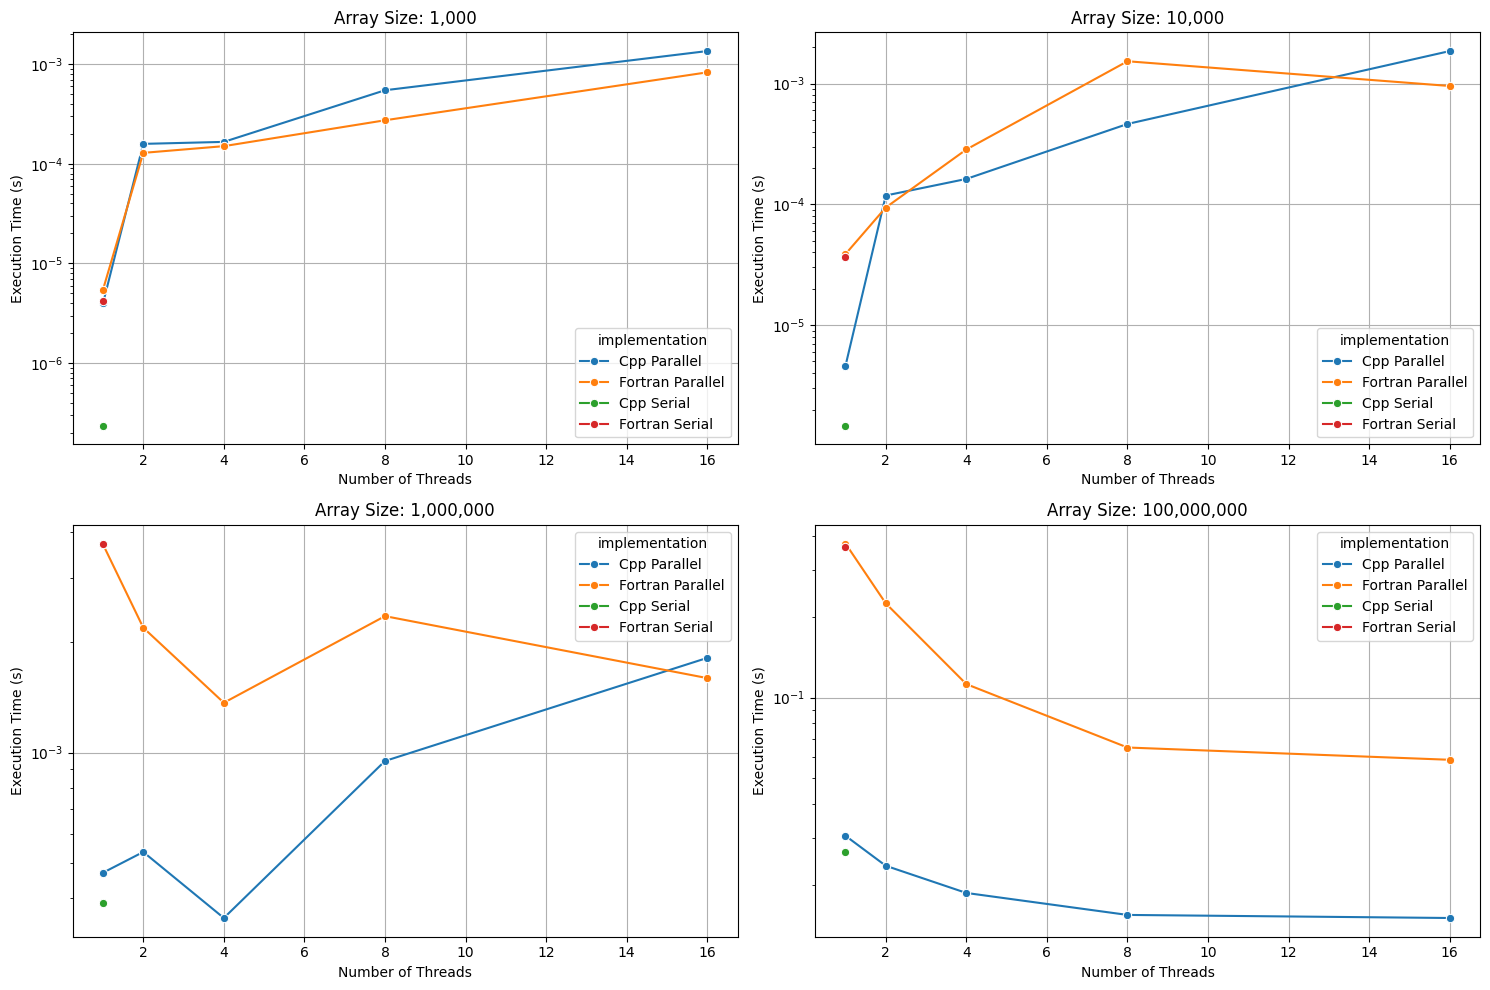

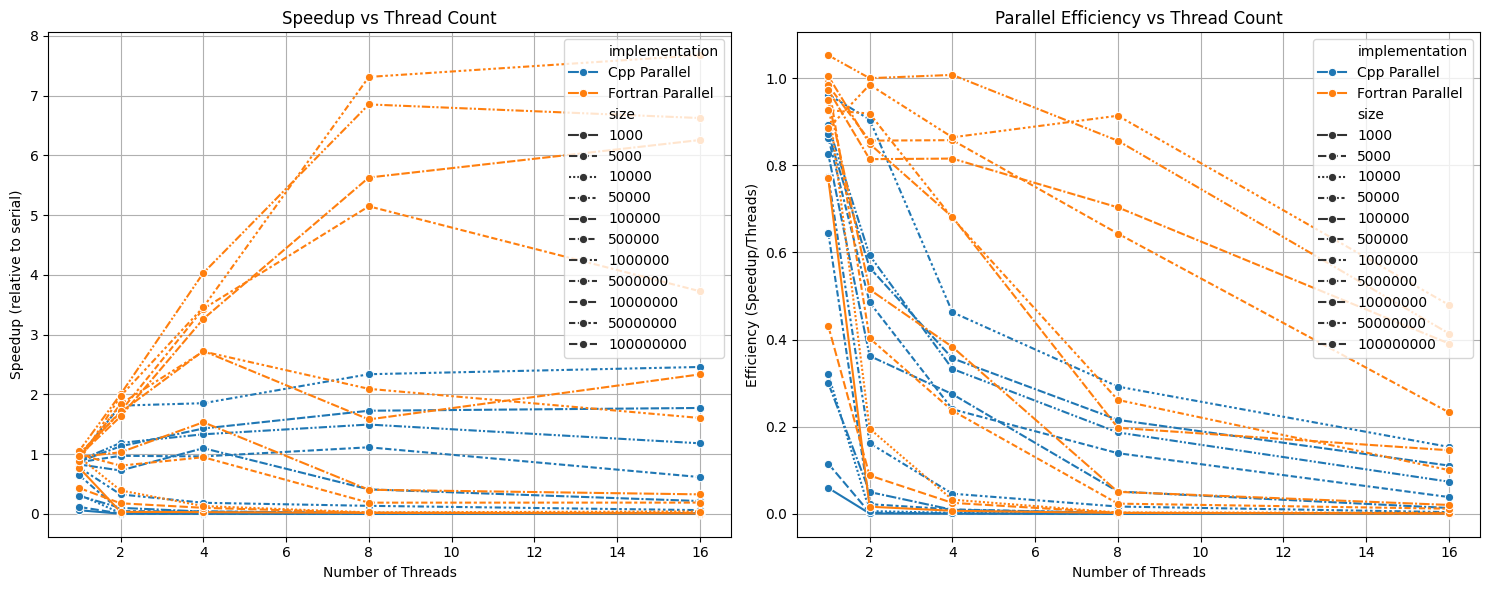

In [14]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def load_and_analyze_benchmarks(json_path):
    """
    Load benchmark data and create comprehensive analysis
    """
    # Load the data
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Convert to DataFrame
    rows = []
    for benchmark in data['benchmarks']:
        size = benchmark['size']
        threads = benchmark['threads']

        # Process parallel implementations
        for impl in ['cpp_parallel', 'fortran_parallel']:
            if benchmark[impl]:
                rows.append({
                    'size': size,
                    'threads': threads,
                    'implementation': impl.replace('_', ' ').title(),
                    'mean_time': benchmark[impl]['mean'],
                    'std_time': benchmark[impl]['std'],
                    'speedup': None  # Will calculate later
                })

        # Process serial implementations
        for impl in ['cpp_serial', 'fortran_serial']:
            if benchmark[impl]:
                rows.append({
                    'size': size,
                    'threads': 1,
                    'implementation': impl.replace('_', ' ').title(),
                    'mean_time': benchmark[impl]['mean'],
                    'std_time': benchmark[impl]['std'],
                    'speedup': 1.0
                })

    df = pd.DataFrame(rows)

    # Calculate speedup relative to serial implementation
    for size in df['size'].unique():
        for impl_type in ['Cpp', 'Fortran']:
            serial_time = df[(df['size'] == size) &
                           (df['implementation'] == f'{impl_type} Serial')]['mean_time'].values[0]

            mask = (df['size'] == size) & (df['implementation'] == f'{impl_type} Parallel')
            df.loc[mask, 'speedup'] = serial_time / df.loc[mask, 'mean_time']

    return df, data['system_info']

def plot_execution_times(df):
    """
    Plot execution times vs thread count for different sizes
    """
    plt.figure(figsize=(15, 10))
    sizes_to_plot = [1000, 10000, 1000000, 100000000]  # Example sizes

    for i, size in enumerate(sizes_to_plot, 1):
        plt.subplot(2, 2, i)
        size_data = df[df['size'] == size]

        sns.lineplot(data=size_data, x='threads', y='mean_time',
                    hue='implementation', marker='o')

        plt.title(f'Array Size: {size:,}')
        plt.xlabel('Number of Threads')
        plt.ylabel('Execution Time (s)')
        plt.yscale('log')
        plt.grid(True)

    plt.tight_layout()
    return plt.gcf()

def plot_speedup_analysis(df):
    """
    Plot speedup analysis comparing C++ and Fortran implementations
    """
    plt.figure(figsize=(15, 6))

    # Speedup vs Threads
    plt.subplot(1, 2, 1)
    sns.lineplot(data=df[df['implementation'].str.contains('Parallel')],
                x='threads', y='speedup', hue='implementation',
                style='size', marker='o')
    plt.title('Speedup vs Thread Count')
    plt.xlabel('Number of Threads')
    plt.ylabel('Speedup (relative to serial)')
    plt.grid(True)

    # Efficiency
    plt.subplot(1, 2, 2)
    df_parallel = df[df['implementation'].str.contains('Parallel')].copy()
    df_parallel['efficiency'] = df_parallel['speedup'] / df_parallel['threads']

    sns.lineplot(data=df_parallel, x='threads', y='efficiency',
                hue='implementation', style='size', marker='o')
    plt.title('Parallel Efficiency vs Thread Count')
    plt.xlabel('Number of Threads')
    plt.ylabel('Efficiency (Speedup/Threads)')
    plt.grid(True)

    plt.tight_layout()
    return plt.gcf()

def calculate_performance_metrics(df):
    """
    Calculate and return key performance metrics
    """
    metrics = {
        'max_speedup': df['speedup'].max(),
        'avg_speedup': df['speedup'].mean(),
        'best_thread_count': df.loc[df['speedup'].idxmax(), 'threads'],
        'best_size': df.loc[df['speedup'].idxmax(), 'size'],
        'best_implementation': df.loc[df['speedup'].idxmax(), 'implementation']
    }

    # Calculate average execution time difference between C++ and Fortran
    cpp_times = df[df['implementation'].str.contains('Cpp')]['mean_time']
    fortran_times = df[df['implementation'].str.contains('Fortran')]['mean_time']
    metrics['avg_cpp_fortran_diff'] = (cpp_times.mean() - fortran_times.mean()) / fortran_times.mean() * 100

    return metrics

# Example usage
if __name__ == "__main__":
    # Load and analyze data
    df, system_info = load_and_analyze_benchmarks('/content/benchmark_20241110_125441.json')

    # Plot execution times
    time_fig = plot_execution_times(df)
    time_fig.savefig('execution_times.png')

    # Plot speedup analysis
    speedup_fig = plot_speedup_analysis(df)
    speedup_fig.savefig('speedup_analysis.png')

    # Calculate and print metrics
    metrics = calculate_performance_metrics(df)
    print("\nPerformance Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")

    # Print system information
    print("\nSystem Information:")
    for key, value in system_info.items():
        print(f"{key}: {value}")